In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import pyproj
import shapely.geometry
from shapely.geometry import Point
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import numpy as np
import xarray as xr
import rioxarray as rxr
from geocube.api.core import make_geocube
import xesmf as xe
import cartopy.crs as ccrs
import contextily as ctx
from scipy import stats

# imports for rasterizing 
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import xwrf

# dask
import dask
from dask.distributed import Client, LocalCluster

Text(35.225572519363496, 0.5, 'Latitude')

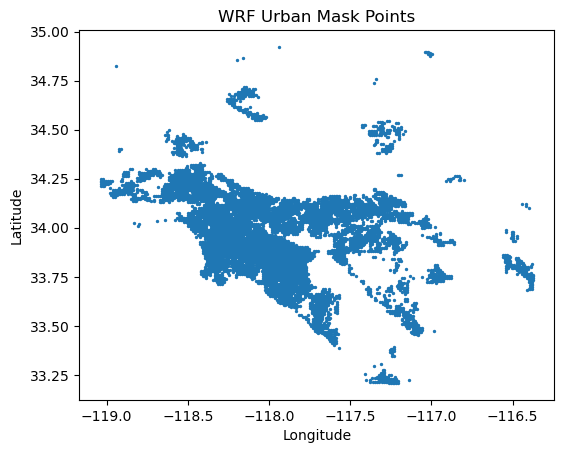

In [2]:
# Load the GeoPackage file
urban_area = gpd.read_file("/home1/kojoseph/ah-la-paper/data/wrf_urban_mask.gpkg")

# Plot the points
urban_area.plot(markersize=2)
plt.title("WRF Urban Mask Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [3]:
# pre-define labels for easy re-use
# \mathrm{} prevents exprsesion from getting italicized 
# \/ within the latex expression is necessary for an empty space
degree_sign = u'\N{DEGREE SIGN}'
del_ta_label = r'$\mathrm{{\Delta}T_{2m}}$ (' + degree_sign + 'C)'
del_tc_label = r'$\mathrm{{\Delta}T_{c}}$ (' + degree_sign + 'C)'
ahf_label = r'Anthropogenic heat flux ($\mathrm{W\/m^{-2}}$)'
ws_label = r'$\mathrm{{\Delta}}$WS ($\mathrm{m\/s^{-1}}$)'
pblh_label = r'$\mathrm{{\Delta}}$PBLH (m)'

# color shortcutes
max_red = '#DD1717'  # red
yale_blue = '#0F4392'  # blue

# where to save plots
plot_dir ='/home1/kojoseph/ah-la-paper/figs/draft_v1'
os.makedirs(plot_dir, exist_ok=True)

# AHF Distribution Analysis

## AHF Heatmaps

In [46]:
home_path = Path('/home1/kojoseph/anthropogenic-heat-la-20230205')
data_path = home_path / 'data'
output_path = data_path / 'output'
plot_path = Path('/home1/kojoseph/ah-la-paper/figs')
diurnal_path = output_path / '20231124/diurnal/08/weekday'
ahf_t = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_traffic.feather')
ahf_b = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_building.feather')
ahf_m = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_metabolism.feather')

In [5]:
filename = 'ahf_diurnal_control_all.feather'
file_path = output_path / '20231124/diurnal/08/weekday' / filename
ahf_all = gpd.read_feather(file_path)

In [6]:
# create daily avg AHF dataframe
ahf_dict = {'t':ahf_t, 'b':ahf_b, 'm':ahf_m}
ahf_avg_dict = {}
for key in ahf_dict:
    df = ahf_dict[key]
    ahf_avg_dict[key] = df.iloc[:, -24:].mean(axis=1)
    
ahf_avg = ahf_t[['FID', 'geometry']].copy()
for key in ahf_avg_dict:
    column_label = 'ahf_' + key
    ahf_avg.insert(len(ahf_avg.columns), column_label, ahf_avg_dict[key])
ahf_avg['ahf_tot'] = ahf_avg['ahf_t'] + ahf_avg['ahf_b'] + ahf_avg['ahf_m']
ahf_avg.head()

,FID,geometry,ahf_t,ahf_b,ahf_m,ahf_tot
0,832323,"POLYGON ((-118.45759 33.95103, -118.45759 33.9...",0.0,0.0,0.0,0.0
1,832324,"POLYGON ((-118.45761 33.95103, -118.45807 33.9...",0.0,0.0,0.0,0.0
2,832325,"POLYGON ((-118.45807 33.95177, -118.45849 33.9...",0.0,0.0,0.0,0.0
3,830804,"POLYGON ((-118.45849 33.95252, -118.45849 33.9...",0.0,0.0,0.0,0.0
4,830805,"POLYGON ((-118.45853 33.95252, -118.45899 33.9...",0.0,0.0,0.0,0.0


In [7]:
# create daily maximum (hr 13) ahf dataframe
ahf_val_dict = {}
for key, df in ahf_dict.items():
    ahf_val_dict[key] = df['ahf_13']   # pick the single column

# Build new GeoDataFrame with FID + geometry
ahf_max = ahf_t[['FID', 'geometry']].copy()

# Insert the selected ahf_13 values
for key in ahf_val_dict:
    column_label = 'ahf_' + key
    ahf_max.insert(len(ahf_max.columns), column_label, ahf_val_dict[key])

# Compute total
ahf_max['ahf_tot'] = ahf_max['ahf_t'] + ahf_max['ahf_b'] + ahf_max['ahf_m']

ahf_max.head()

,FID,geometry,ahf_t,ahf_b,ahf_m,ahf_tot
0,832323,"POLYGON ((-118.45759 33.95103, -118.45759 33.9...",0.0,0.0,0.0,0.0
1,832324,"POLYGON ((-118.45761 33.95103, -118.45807 33.9...",0.0,0.0,0.0,0.0
2,832325,"POLYGON ((-118.45807 33.95177, -118.45849 33.9...",0.0,0.0,0.0,0.0
3,830804,"POLYGON ((-118.45849 33.95252, -118.45849 33.9...",0.0,0.0,0.0,0.0
4,830805,"POLYGON ((-118.45853 33.95252, -118.45899 33.9...",0.0,0.0,0.0,0.0


In [8]:
ahf_max.shape

(1571040, 6)

In [9]:
gdf_m = ahf_max.to_crs(epsg=32611)  # project to meters (important!)
# Choose your target resolution (50 meters)
resolution = 100

# Floor coordinates to nearest multiple of 50 m
gdf_m["x"] = (gdf_m.geometry.centroid.x // resolution) * resolution
gdf_m["y"] = (gdf_m.geometry.centroid.y // resolution) * resolution
len(gdf_m['x'].unique())

1211

In [10]:
len(gdf_m['y'].unique())

1250

In [ ]:
# Rasterize into xarray dataset
import numpy as np
import xarray as xr
import geopandas as gpd

# Assume gdf is your large GeoDataFrame
gdf_m = ahf_max.to_crs(epsg=32611)  # project to meters (important!)

# Choose your target resolution (50 meters)
resolution = 100

# Floor coordinates to nearest multiple of 50 m
gdf_m["x"] = (gdf_m.geometry.centroid.x // resolution) * resolution
gdf_m["y"] = (gdf_m.geometry.centroid.y // resolution) * resolution

# Find unique sorted coordinates
x_coords = np.sort(gdf_m["x"].unique())
y_coords = np.sort(gdf_m["y"].unique())[::-1]  # descending so north at top

nx = len(x_coords)
ny = len(y_coords)

# build mapping from coordinate value -> array index
x_index = {x: i for i, x in enumerate(x_coords)}
y_index = {y: i for i, y in enumerate(y_coords)}

# Convert x/y to index arrays (vectorized)
x_idx = gdf_m["x"].map(x_index).to_numpy()
y_idx = gdf_m["y"].map(y_index).to_numpy()

# Build data variables
data_vars = {}
for col in ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]:
    arr = np.full((ny, nx), np.nan, dtype="float32")
    arr[y_idx, x_idx] = gdf_m[col].to_numpy()
    data_vars[col] = (("y", "x"), arr)

# Build xarray Dataset
ds = xr.Dataset(
    data_vars=data_vars,
    coords={"x": x_coords, "y": y_coords},
    attrs={"crs": gdf_m.crs.to_string(), "resolution": 100}  # 50 m grid
)

print(ds)

<xarray.Dataset>
Dimensions:  (y: 1250, x: 1211)
Coordinates:
  * x        (x) float64 3.2e+05 3.201e+05 3.202e+05 ... 4.409e+05 4.41e+05
  * y        (y) float64 3.854e+06 3.854e+06 3.854e+06 ... 3.73e+06 3.73e+06
Data variables:
    ahf_t    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_b    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_m    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_tot  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    crs:         EPSG:32611
    resolution:  100


In [70]:
# remove everything under 1 W/m2 (turn to nan)
ds_nonan = ds.where(ds >= 0.1, np.nan)

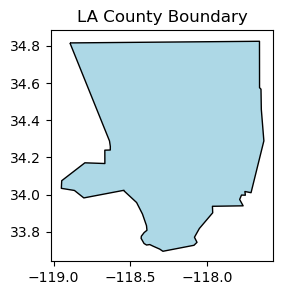

epsg:4326


In [37]:
la_county_filepath='/home1/kojoseph/anthropogenic-heat-la-20230205/data/boundaries/la_county_bound_simplified_3.geojson'
la_county_gdf = gpd.read_file(la_county_filepath)

# Plot
fig, ax = plt.subplots(figsize=(3, 3))
la_county_gdf.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title("LA County Boundary")
plt.show()

print(la_county_gdf)

In [36]:
ds_nonan.crs

'EPSG:32611'

In [68]:
la_county_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [108]:
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# from matplotlib.ticker import ScalarFormatter
# import geopandas as gpd

# # Reproject LA County GeoDataFrame to match xarray CRS
# la_county_gdf_utm = la_county_gdf.to_crs(ds_nonan.crs)

# variables = ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]
# # cmaps = ["OrRd", "OrRd", "OrRd", "OrRd"]
# cmaps = ["magma_r", "magma_r", "magma_r", "magma_r"]
# vmax_values = [1000, 1000, 10, 1000]
# vmin = 0.1

# # Titles with subscripts (non-italic using \mathrm{})
# titles = [r"AHF$_{\mathrm{traffic}}$", r"AHF$_{\mathrm{buildings}}$",
#           r"AHF$_{\mathrm{metabolism}}$", r"AHF$_{\mathrm{total}}$"]

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# axes = axes.flatten()

# # Font sizes
# title_fs = 16
# label_fs = 14
# tick_fs = 12
# cb_label_fs = 14

# for i, var in enumerate(variables):
#     # Plot xarray variable
#     im = ds_nonan[var].plot.imshow(
#         x='x',
#         y='y',
#         cmap=cmaps[i],
#         norm=LogNorm(vmin=vmin, vmax=vmax_values[i]),
#         interpolation='none',
#         ax=axes[i],
#         add_colorbar=False
#     )
#     # Overlay LA County boundary
#     la_county_gdf_utm.boundary.plot(ax=axes[i], color='black', linewidth=2)

#     axes[i].set_aspect('equal')
#     axes[i].set_title(titles[i], fontsize=title_fs)
#     axes[i].set_xlabel("X (meters)", fontsize=label_fs)
#     axes[i].set_ylabel("Y (meters)", fontsize=label_fs)

#     # Use scientific notation for both axes
#     axes[i].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     axes[i].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     axes[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     axes[i].tick_params(labelsize=tick_fs)

#     # Add colorbar manually with extend='max'
#     cbar = plt.colorbar(im, ax=axes[i], shrink=0.8, pad=0.02, extend='max')
#     cbar.set_label("AHF (W/m²)", fontsize=cb_label_fs)
#     cbar.ax.tick_params(labelsize=tick_fs-1)

#     # Update colorbar label
#     im.colorbar.set_label("AHF (W/m²)", fontsize=cb_label_fs)

# plt.tight_layout(h_pad=1.0, w_pad=0.1)  # reduce w_pad to bring columns closer
# save_path = plot_path / 'draft_v1/ahf_plots.png'
# # fig.savefig(save_path, dpi=300, bbox_inches='tight') # save plot
# plt.show()

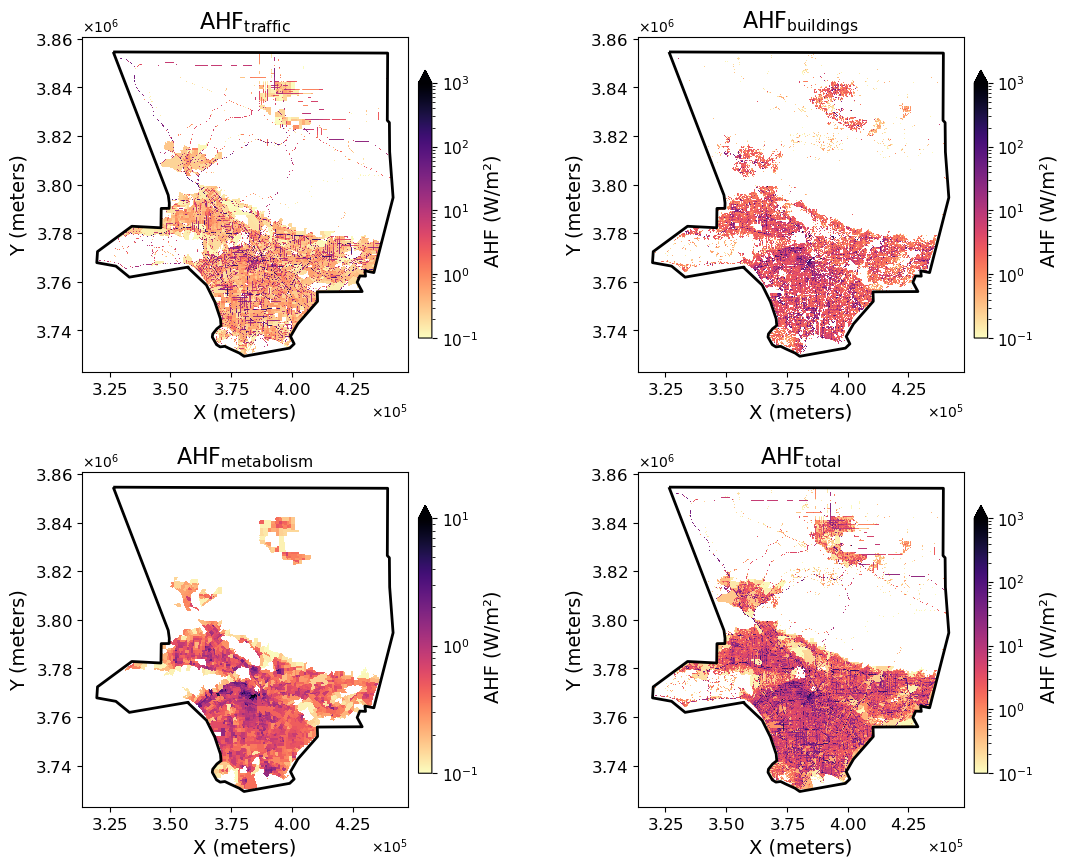

In [109]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
import geopandas as gpd

# Reproject LA County GeoDataFrame
la_county_gdf_utm = la_county_gdf.to_crs(ds_nonan.crs)

variables = ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]
cmaps = ["magma_r"]*4
vmax_values = [1000, 1000, 10, 1000]
vmin = 0.1
titles = [r"AHF$_{\mathrm{traffic}}$", r"AHF$_{\mathrm{buildings}}$",
          r"AHF$_{\mathrm{metabolism}}$", r"AHF$_{\mathrm{total}}$"]

# Create figure with gridspec
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, wspace=0.05, hspace=0.3)  # set spacing here

title_fs = 16
label_fs = 14
tick_fs = 12
cb_label_fs = 14

for i, var in enumerate(variables):
    ax = fig.add_subplot(gs[i])
    
    # Plot data without colorbar
    im = ds_nonan[var].plot.imshow(
        x='x', y='y',
        cmap=cmaps[i],
        norm=LogNorm(vmin=vmin, vmax=vmax_values[i]),
        interpolation='none',
        ax=ax,
        add_colorbar=False
    )
    
    # Overlay LA County boundary
    la_county_gdf_utm.boundary.plot(ax=ax, color='black', linewidth=2)

    ax.set_aspect('equal')
    ax.set_title(titles[i], fontsize=title_fs)
    ax.set_xlabel("X (meters)", fontsize=label_fs)
    ax.set_ylabel("Y (meters)", fontsize=label_fs)
    
    # Axes formatting
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.tick_params(labelsize=tick_fs)
    
    # Add colorbar manually
    cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02, extend='max')
    cbar.set_label("AHF (W/m²)", fontsize=cb_label_fs)
    cbar.ax.tick_params(labelsize=tick_fs-1)

save_path = plot_path / 'draft_v1/ahf_plots.png'
fig.savefig(save_path, dpi=300, bbox_inches='tight') # save plot
plt.show()

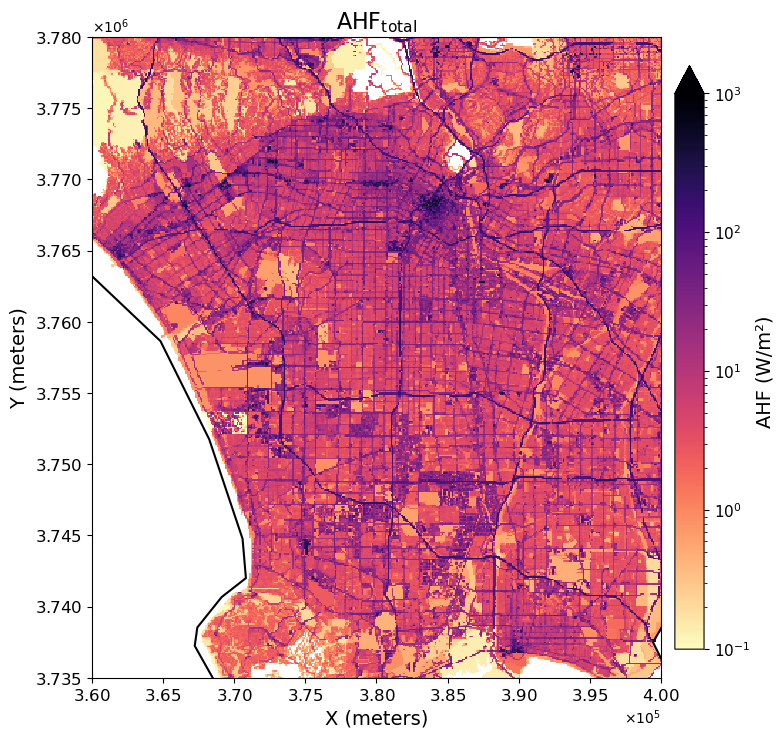

In [112]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter

# Reproject LA County boundary to match xarray CRS
la_county_gdf_utm = la_county_gdf.to_crs(ds_nonan.crs)

# Select variable
var = "ahf_tot"
vmin = 0.1
vmax = 1000
cmap = "magma_r"
title = r"AHF$_{\mathrm{total}}$"

# Define zoomed-in limits (in meters, adjust as needed)
xlim_zoom = (3.6e5, 4.0e5)
ylim_zoom = (3.735e6, 3.78e6)

fig, ax = plt.subplots(figsize=(8, 8))  # square figure is fine, aspect is set by CRS

# Plot
im = ds_nonan[var].plot.imshow(
    x='x',
    y='y',
    cmap=cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    interpolation='none',
    ax=ax,
    add_colorbar=False
)

# Overlay LA County boundary
la_county_gdf_utm.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Set zoomed-in limits
ax.set_xlim(xlim_zoom)
ax.set_ylim(ylim_zoom)

# Maintain true CRS aspect ratio (meters in x and y are equal)
ax.set_aspect('equal')

ax.set_title(title, fontsize=16)
ax.set_xlabel("X (meters)", fontsize=14)
ax.set_ylabel("Y (meters)", fontsize=14)

# Scientific notation for axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02, extend='max')
cbar.set_label("AHF (W/m²)", fontsize=14)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
save_path = plot_path / 'draft_v1/ahf_total_zoom.png'
fig.savefig(save_path, dpi=300, bbox_inches='tight') # save plot
plt.show()


In [66]:
# # If you want the figure in lat/lon
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm
# from matplotlib.ticker import ScalarFormatter
# from rasterio.enums import Resampling
# import geopandas as gpd
# import rioxarray
# import numpy as np

# # --- Reproject xarray Dataset to EPSG:4326 ---
# ds_4326 = ds_nonan.rio.write_crs("EPSG:32611", inplace=False).rio.reproject("EPSG:4326")

# # Reproject LA County boundary to EPSG:4326
# la_county_gdf_4326 = la_county_gdf.to_crs(epsg=4326)

# def mask_edge_pixels(data_array, edge_pixels=2):
#     """Remove edge pixels that often contain artifacts"""
#     masked = data_array.copy()
#     masked[:edge_pixels, :] = np.nan
#     masked[-edge_pixels:, :] = np.nan
#     masked[:, :edge_pixels] = np.nan
#     masked[:, -edge_pixels:] = np.nan
#     return masked

# # Variables and plot settings
# variables = ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]
# cmaps = ["OrRd", "OrRd", "OrRd", "OrRd"]
# vmax_values = [1000, 100, 10, 1000]
# vmin = 0.1
# titles = [r"AHF$_{\mathrm{traffic}}$", r"AHF$_{\mathrm{buildings}}$",
#           r"AHF$_{\mathrm{metabolism}}$", r"AHF$_{\mathrm{total}}$"]

# # Get bounds from the data
# x_min, x_max = float(ds_4326['x'].min()), float(ds_4326['x'].max())
# y_min, y_max = float(ds_4326['y'].min()), float(ds_4326['y'].max())

# # Create figure
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# axes = axes.flatten()

# title_fs = 16
# label_fs = 14
# tick_fs = 12
# cb_label_fs = 14

# # Increased buffer for zoom out
# buffer_x = 0.05 * (x_max - x_min)
# buffer_y = 0.05 * (y_max - y_min)
# extent = [x_min - buffer_x, x_max + buffer_x, y_min - buffer_y, y_max + buffer_y]

# for i, var in enumerate(variables):
#     # Mask edges
#     data = ds_4326[var].values
#     data_masked = mask_edge_pixels(data, edge_pixels=3)
#     data_clean = ds_4326[var].copy()
#     data_clean.values = data_masked

#     # Remove extreme outliers
#     data_clean = data_clean.where(
#         (data_clean >= vmin) &
#         (data_clean <= vmax_values[i]) &
#         np.isfinite(data_clean)
#     )

#     # Plot
#     im = data_clean.plot.imshow(
#         x='x', y='y',
#         cmap=cmaps[i],
#         norm=LogNorm(vmin=vmin, vmax=vmax_values[i]),
#         interpolation='none',
#         ax=axes[i],
#         add_colorbar=False
#     )

#     # Overlay LA County boundary
#     la_county_gdf_4326.boundary.plot(ax=axes[i], color='black', linewidth=1)

#     axes[i].set_aspect('equal')
#     axes[i].set_title(titles[i], fontsize=title_fs)
#     axes[i].set_xlabel("Longitude (°)", fontsize=label_fs)
#     axes[i].set_ylabel("Latitude (°)", fontsize=label_fs)

#     # Set expanded extent (zoomed out)
#     axes[i].set_xlim(extent[0], extent[1])
#     axes[i].set_ylim(extent[2], extent[3])

#     # Add faint grid lines
#     axes[i].grid(True, color='gray', linestyle='--', alpha=0.3)

#     # Format axes
#     axes[i].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     axes[i].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     axes[i].tick_params(labelsize=tick_fs)

#     # Colorbar with open upper limit
#     cbar = plt.colorbar(im, ax=axes[i], shrink=0.8, pad=0.02, extend='max')
#     cbar.set_label("AHF (W/m²)", fontsize=cb_label_fs)
#     cbar.ax.tick_params(labelsize=tick_fs-1)

# plt.tight_layout()
# save_path = plot_path / 'draft_v1/ahf_plots_epsg4326_zoomed.png'
# # fig.savefig(save_path, dpi=300, bbox_inches='tight')
# plt.show()


## 

In [ ]:
%%time 
# plot to visualize
subset_bounds = (-118.3, 34.00, -118.2, 34.10)
xmin, ymin, xmax, ymax = subset_bounds
ahf_subset = ahf_avg.cx[xmin:xmax, ymin:ymax]
fig, ax = plt.subplots(figsize=(6,6))
cmap = mpl.cm.jet
bounds = [0.1, 1, 5, 10, 20, 50]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
ahf_subset.plot(ax=ax, column='ahf_m', alpha=0.7, legend=True, 
              cmap=cmap, vmin=0, norm=norm,
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]',
                          'shrink':0.7})

# Default - Control

Assuming deltas have been pre-computed and saved using `deltas-analysis.py` script.

In [ ]:
# import deltas data
deltas = {}
data_dir = '/home1/kojoseph/ah-la-paper/data/deltas-urban-wrf'
nc_files = glob.glob(f"{data_dir}/*.nc")
for f in nc_files:
    filename = os.path.basename(f)
    delta_id = filename.split('.')[0]
    ds = xr.open_dataset(f)
    deltas[delta_id] = ds

## T2 (2 meter air temperature)

In [ ]:
# Diurnal plot for delta(T2)
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_ta_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(0, 0.5)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-t2-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

In [ ]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-0.5, 1.5)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_ta_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-t2-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [ ]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

## TC_URB (canopy air temperature)

In [ ]:
# Diurnal plot for delta(T2)
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_tc_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(0, 2.5)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-tc-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")         

In [ ]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-0.5, 4.0)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_tc_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-tc-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [ ]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

## WS (Wind Speed)

In [ ]:
# Diurnal plot for delta(T2)
v = 'WS'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(ws_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(-0.1, 0.2)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-ws-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)            

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

In [ ]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-1.0, 1.0)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(ws_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-ws-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [ ]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

## PBL

In [ ]:
# Diurnal plot for delta(T2)
v = 'PBLH'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)

ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(pblh_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(-50, 120)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-pbl-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

Note: for histograms and statistical tests, coarsen PBL to 10km first. 

In [ ]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-50, 100)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    ds = deltas[delta_id][v]
    ds = ds.coarsen(y=10, x=10, boundary='trim').mean() # coarsen to 10km
    delta_dict[m] = ds
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]

# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(pblh_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# ax.set_yscale('log')  # <-- Add this line for log scale on y-axis
# save plot
save_filename = 'hist-pbl-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [ ]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta = delta.coarsen(y=10, x=10, boundary='trim').mean() # coarsen to 10km
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")